In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
from collections import defaultdict
import gseapy as gp
import anndata
from scipy import stats
from adjustText import adjust_text
from plot_utils import *
from pyscenic.aucell import aucell
import scvi
from ctxcore.genesig import GeneSignature
sns.set_style('whitegrid')

Global seed set to 0


In [3]:
outdir = '../results'
figdir = f'{outdir}/overleaf/figures'
dataset = 'Adamson2016'
seed = 1
file = f'../data/{dataset.lower()}/{dataset.lower()}_{seed}.h5ad'

In [4]:
adata = anndata.read_h5ad(file)

In [5]:
adata

AnnData object with n_obs × n_vars = 65899 × 5060
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'split'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'

In [7]:
adata.obs['control_str'] = adata.obs['control'].astype(str)
adata.obs['control'].astype(str), set(adata.obs['control_str'].values)

(cell_barcode
 AAACATACACCGAT-1     0
 AAACATACAGAGAT-1     1
 AAACATACCAGAAA-1     1
 AAACATACGTTGAC-1     1
 AAACATACTGTTCT-1     1
                     ..
 TTTGCATGCCTATT-10    0
 TTTGCATGCTTTAC-10    0
 TTTGCATGGAGGAC-10    0
 TTTGCATGTAGAGA-10    1
 TTTGCATGTGGAGG-10    0
 Name: control, Length: 65899, dtype: object,
 {'0', '1'})

#### Enrichment analysis

In [5]:
df = adata.to_df().T
df.index = adata.var.loc[df.index]['gene_name']
adata.obs['control_str'] = adata.obs['control'].astype(str)
res = gp.gsea(data=df.reset_index(), # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=adata.obs['control_str'].values,
        permutation_num=500,
        permutation_type='phenotype',
        min_size=5,
        max_size=1000,
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
# res.res2d.to_csv(f'{outdir}/{dataset}_gsea_bp.csv')

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/gsea.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True)


/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


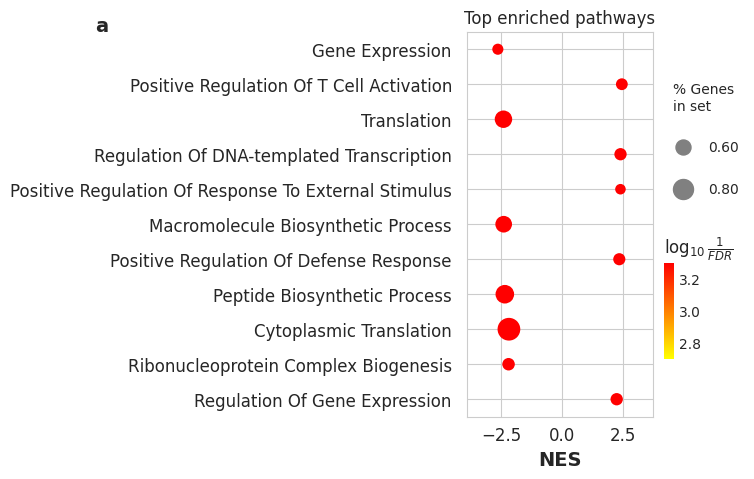

In [6]:
fontsize = 12
res_ = res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
ax = gp.dotplot(res_,
           column='FDR q-val',
           figsize=(3,5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=3,
           top_term=11,
           cmap = plt.cm.autumn_r)
letter_annotation(ax, -2, 1, 'a', fontsize=14)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Top enriched pathways', fontsize=12);
# plt.savefig(f'{figdir}/{dataset}_top_pathway_enrichment_fd.pdf', bbox_inches='tight');

In [7]:
# Select specific pathways
# keywords = ['heat', 'unfolded', 'dna damage', 'cell death', 'oxidative', 'stress', 'autophagy', 'apopt', 'external']
keywords = ['heat', 'unfolded', 'cell death', 'stress']
m = [any([k in x.lower() for k in keywords]) for x in res.res2d['Term'].values]
selected_pathways = np.unique(res.res2d['Term'].values[m])
res_selected = res.res2d[res.res2d['Term'].isin(selected_pathways)]

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


Text(0.5, 1.0, 'Enriched stress-related pathways')

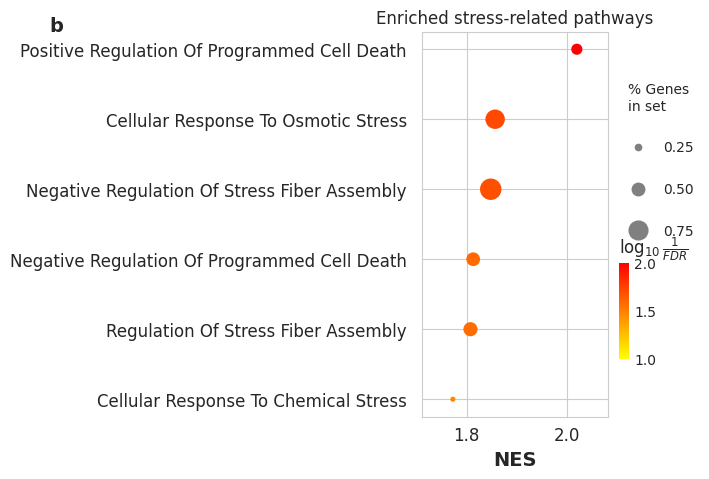

In [8]:
res_selected_ = res_selected.copy()
res_selected_['Term'] = res_selected_['Term'].str.split('(').str[0]
ax = gp.dotplot(res_selected_,
           column='FDR q-val',
           figsize=(3,5),
           title="Enriched stress-related pathways",
           show_ring=False,
           size=3,
           top_term=20,
           cmap = plt.cm.autumn_r)
letter_annotation(ax, -2, 1, 'b', fontsize=14)
# plt.ylabel(plt.gca().yaxis.get_label(), fontsize=4)
plt.yticks(fontsize=fontsize);
plt.xticks(fontsize=fontsize);
plt.xlabel('NES', fontsize=14);
plt.title('Enriched stress-related pathways', fontsize=12)
# plt.savefig(f'{figdir}/{dataset}_stress_pathway_enrichment_fd.pdf', bbox_inches='tight');

#### Volcano plots

In [45]:
adata

AnnData object with n_obs × n_vars = 65337 × 32738
    obs: 'perturbation', 'read count', 'UMI count', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [46]:
adata.obs

perturbation  read count  UMI count tissue_type cell_line  \
cell_barcode                                                                   
AAACATACAAGATG   63(mod)_pBA580       282.0        8.0   cell_line      K562   
AAACATACACCTAG      OST4_pDS353       331.0        7.0   cell_line      K562   
AAACATACTTCCCG   SEC61A1_pDS031       285.0       10.0   cell_line      K562   
AAACATTGAAACAG    EIF2B4_pDS491      1036.0       30.0   cell_line      K562   
AAACATTGCAGCTA      SRPR_pDS482       863.0       25.0   cell_line      K562   
...                         ...         ...        ...         ...       ...   
TTTGCATGCTTTAC     STT3A_pDS011       476.0       17.0   cell_line      K562   
TTTGCATGGAGGAC  ARHGAP22_pDS458       539.0       19.0   cell_line      K562   
TTTGCATGTAGAGA   63(mod)_pBA580       647.0       35.0   cell_line      K562   
TTTGCATGTCAAGC    KCTD16_pDS096        98.0        4.0   cell_line      K562   
TTTGCATGTGGAGG    SAMM50_pDS156       427.0       14.0   cell_line      K562   

                cancer                       disease perturbation_type  \
cell_barcode                                                             
AAACATACAAGATG    True  chronic myelogenous leukemia            CRISPR   
AAACATACACCTAG    True  chronic myelogenous leukemia            CRISPR   
AAACATACTTCCCG    True  chronic myelogenous leukemia            CRISPR   
AAACATTGAAACAG    True  chronic myelogenous leukemia            CRISPR   
AAACATTGCAGCTA    True  chronic myelogenous leukemia            CRISPR   
...                ...                           ...               ...   
TTTGCATGCTTTAC    True  chronic myelogenous leukemia            CRISPR   
TTTGCATGGAGGAC    True  chronic myelogenous leukemia            CRISPR   
TTTGCATGTAGAGA    True  chronic myelogenous leukemia            CRISPR   
TTTGCATGTCAAGC    True  chronic myelogenous leukemia            CRISPR   
TTTGCATGTGGAGG    True  chronic myelogenous leukemia            CRISPR   

                    celltype organism  ncounts  ngenes  percent_mito  \
cell_barcode                                                           
AAACATACAAGATG  lymphoblasts    human   8866.0    2914      4.917663   
AAACATACACCTAG  lymphoblasts    human  13785.0    3818      4.468626   
AAACATACTTCCCG  lymphoblasts    human   7569.0    2616      5.060113   
AAACATTGAAACAG  lymphoblasts    human  13834.0    3488      5.052769   
AAACATTGCAGCTA  lymphoblasts    human  15507.0    3620      4.514091   
...                      ...      ...      ...     ...           ...   
TTTGCATGCTTTAC  lymphoblasts    human  14524.0    3356      5.996971   
TTTGCATGGAGGAC  lymphoblasts    human  11685.0    2961      4.612751   
TTTGCATGTAGAGA  lymphoblasts    human  16610.0    3473      7.242625   
TTTGCATGTCAAGC  lymphoblasts    human  14473.0    3431      7.296345   
TTTGCATGTGGAGG  lymphoblasts    human  16843.0    3719      5.919373   

                percent_ribo  nperts  
cell_barcode                          
AAACATACAAGATG     21.306112       2  
AAACATACACCTAG     19.492201       2  
AAACATACTTCCCG     23.199894       2  
AAACATTGAAACAG     28.733555       2  
AAACATTGCAGCTA     26.729864       2  
...                      ...     ...  
TTTGCATGCTTTAC     22.679703       2  
TTTGCATGGAGGAC     26.983313       2  
TTTGCATGTAGAGA     26.207104       2  
TTTGCATGTCAAGC     20.755890       2  
TTTGCATGTGGAGG     20.097370       2  

[65337 rows x 15 columns]

In [ ]:
from pertpy.data import adamson_2016_upr_perturb_seq
adata = adamson_2016_upr_perturb_seq()

In [51]:
adata.obs['perturbation'].value_counts()

perturbation
63(mod)_pBA580        6010
Gal4-4(mod)_pBA582    1283
IER3IP1_pDS002        1222
SEC61B_pDS033         1185
ASCC3_pDS052          1142
                      ... 
ATF6_pBA586             10
YIPF5_pDS001             9
ATF4_pBA576              5
62(mod)_pBA581           2
STT3A_pDS010             1
Name: count, Length: 114, dtype: int64

In [16]:
pvals = []
# X = adata.layers['counts']
# X = 1e6 * X / X.sum(axis=1)[:, None]
# X = np.log1p(X)
X = adata.X.toarray()
X_ctl = X[adata.obs['control'] == 1]
X_pert = X[adata.obs['control'] == 0]
for i in tqdm(range(adata.shape[-1])):
    t_statistic, p_values = stats.ttest_ind(X_pert[:, i], X_ctl[:, i])
    pvals.append(p_values)
pvals = np.array(pvals)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5060/5060 [00:11<00:00, 423.54it/s]


In [19]:
res_.iloc[:20]

Name                                               Term        ES  \
0   gsea                                   Gene Expression  -0.718676   
1   gsea          Positive Regulation Of T Cell Activation   0.696175   
2   gsea                                       Translation  -0.901838   
3   gsea         Regulation Of DNA-templated Transcription   0.500502   
4   gsea  Positive Regulation Of Response To External St...  0.663734   
5   gsea                Macromolecule Biosynthetic Process   -0.85511   
6   gsea           Positive Regulation Of Defense Response   0.681838   
7   gsea                      Peptide Biosynthetic Process  -0.905565   
8   gsea      Positive Regulation Of Inflammatory Response   0.677498   
9   gsea  Positive Regulation Of Nucleic Acid-Templated ...  0.499754   
10  gsea        Positive Regulation Of Cytokine Production   0.529338   
11  gsea                     Regulation Of Gene Expression   0.477582   
12  gsea                          Regulation Of DNA Repair   0.731315   
13  gsea   Regulation Of Intracellular Signal Transduction   0.545164   
14  gsea                            Organelle Organization   0.534508   
15  gsea  Negative Regulation Of Epithelial Cell Prolife...  0.692244   
16  gsea          Negative Regulation Of Protein Secretion   0.836397   
17  gsea                       Regulation Of Cell Motility    0.64435   
18  gsea  Regulation Of Nucleic Acid-Templated Transcrip...  0.513472   
19  gsea  Positive Regulation Of Lymphocyte Differentiat...   0.81245   

         NES NOM p-val FDR q-val FWER p-val    Tag %  Gene %  \
0   -2.64144       0.0       0.0        0.0    36/81   3.97%   
1   2.464562       0.0       0.0        0.0    17/36  13.99%   
2   -2.41044       0.0       0.0        0.0    30/43   3.48%   
3   2.409378       0.0       0.0        0.0  217/441  31.72%   
4   2.407037       0.0       0.0        0.0    19/45  19.33%   
5  -2.401087       0.0       0.0        0.0    30/45   3.48%   
6   2.359283       0.0       0.0        0.0    17/35  19.33%   
7  -2.354011       0.0       0.0        0.0    29/39   3.48%   
8    2.27309       0.0  0.000728      0.002    13/28  17.19%   
9   2.254787       0.0  0.000607      0.002   80/156  31.60%   
10  2.253808       0.0   0.00052      0.002   46/100  27.47%   
11  2.252229       0.0  0.000455      0.002  143/290  31.60%   
12  2.244749       0.0  0.001213      0.006    22/27  20.16%   
13  2.240571       0.0  0.001092      0.006    39/83  24.76%   
14  2.238837       0.0  0.000993      0.006    51/97  29.03%   
15  2.233671       0.0   0.00091      0.006    11/25  18.28%   
16  2.230081       0.0   0.00112      0.008     5/11   7.31%   
17  2.228207       0.0   0.00104      0.008    15/36  15.47%   
18  2.222317       0.0  0.000971      0.008   60/116  30.26%   
19  2.221483       0.0   0.00091      0.008     9/13  13.99%   

                                           Lead_genes  
0   RPS21;RPL37;RPL37A;RPS28;RPS29;RPL28;RPS15A;RP...  
1   B2M;MDK;AIF1;PYCARD;HLA-A;SMARCC1;CD47;RHOH;AC...  
2   RPS21;RPL37;RPL37A;RPS28;RPS29;RPL28;RPS15A;RP...  
3   PRAME;APOE;PARP1;CITED2;LIMS1;GPBP1;BTG1;CTCFL...  
4   CYBA;MDK;AIF1;PYCARD;NFKBIA;LGALS1;GRN;EMILIN2...  
5   RPS21;RPL37;RPL37A;RPS28;RPS29;RPL28;RPS15A;RP...  
6   CYBA;MDK;PYCARD;NFKBIA;LGALS1;GRN;EMILIN2;CD47...  
7   RPS21;RPL37;RPL37A;RPS28;RPS29;RPL28;RPS15A;RP...  
8   MDK;PYCARD;NFKBIA;LGALS1;GRN;CD47;LCP1;NUPR1;I...  
9   APOE;CITED2;CTCFL;REST;CEBPB;ELF1;KMT2E;SMARCC...  
10  CYBA;FCER1G;MDK;AIF1;PYCARD;LAPTM5;HLA-A;PTPN1...  
11  APOE;ERP29;AIF1;SETD2;CITED2;LIMS1;GPBP1;BTG1;...  
12  PARP1;SMARCC1;RNF168;YY1;EPC1;TRIP12;PPP4R2;AC...  
13  PYCARD;NFKBIA;ATP6AP2;TMSB4X;ARHGAP5;NTRK1;ARH...  
14  SH3BGRL3;APOE;MDK;TMED9;PARP1;DST;ZMYM4;YTHDF2...  
15  B2M;APOE;NUPR1;CDK6;DUSP10;CDKN1C;BRCA2;NF1;TG...  
16                    APOE;ERP29;REST;RSAD2;RAB11FIP1  
17  MACF1;TMSB4X;SPINT2;KIF2A;BEX4;ARHGAP18;FYN;CD...  
18  GPBP1;BTG1;ASH1L;SMARCA5;REST;CEBPB;ATF4;ZNF28...  
19  M

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

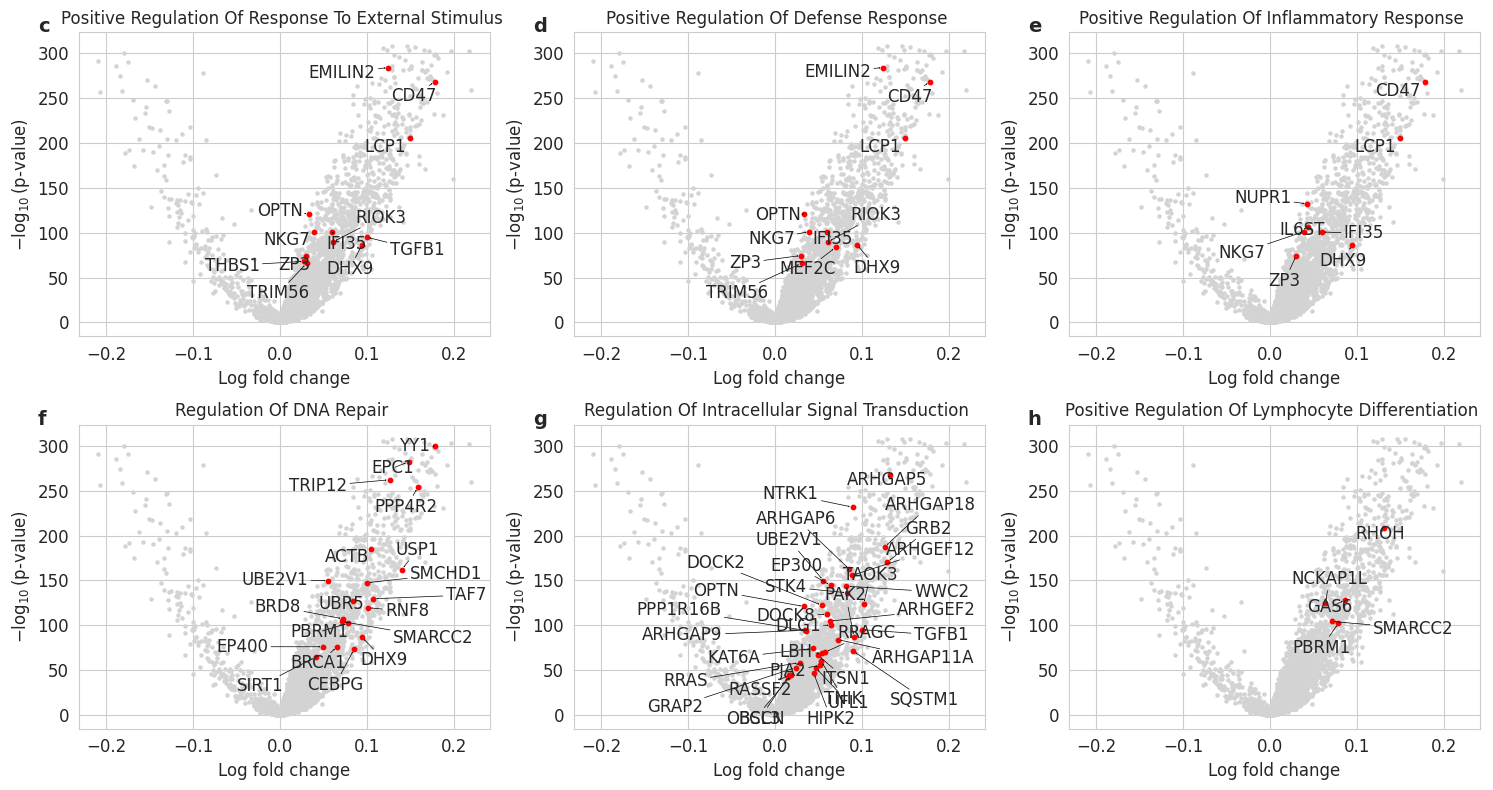

In [20]:
idxs = [4, 6, 8, 12, 13, 19]
nrows = 2
ncols = 3
fontsize=12
eps = 1e-1000

x = X_pert.mean(0) - X_ctl.mean(0)
y = -np.log10(pvals + eps)
gene_names = adata.var['gene_name']
res_ = res.res2d.copy()
res_['Term'] = res_['Term'].str.split('(').str[0]
fig = plt.figure(figsize=(ncols*5, nrows*4))
for i, idx in enumerate(idxs):
    row = res_.loc[idx]
    plt.subplot(nrows, ncols, i+1)
    letter_annotation(plt.gca(), -.1, 1, chr(99 + i), fontsize=14)
    volcano_plot(x, y, row, gene_names, fontsize=fontsize)
plt.tight_layout()
# plt.savefig(f'{figdir}/{dataset}_volcano_combined.pdf', bbox_inches='tight');

#### Score cells

In [6]:
enr_results_df = pd.read_csv(f'{outdir}/{dataset}_gsea_bp.csv', index_col=0)

In [7]:
enr_results_df = res.res2d

NameError: name 'res' is not defined

In [8]:
keywords = ['heat', 'unfolded', 'cell death', 'stress']
m = [any([k in x.lower() for k in keywords]) for x in enr_results_df['Term'].values]
selected_pathways = np.unique(enr_results_df['Term'].values[m])
selected_pathways

array(['Cellular Response To Chemical Stress (GO:0062197)',
       'Cellular Response To Heat (GO:0034605)',
       'Cellular Response To Osmotic Stress (GO:0071470)',
       'Cellular Response To Oxidative Stress (GO:0034599)',
       'Cellular Response To Unfolded Protein (GO:0034620)',
       'Integrated Stress Response Signaling (GO:0140467)',
       'Intrinsic Apoptotic Signaling Pathway In Response To Endoplasmic Reticulum Stress (GO:0070059)',
       'Negative Regulation Of Cell Death (GO:0060548)',
       'Negative Regulation Of Endoplasmic Reticulum Stress-Induced Intrinsic Apoptotic Signaling Pathway (GO:1902236)',
       'Negative Regulation Of Endoplasmic Reticulum Unfolded Protein Response (GO:1900102)',
       'Negative Regulation Of Oxidative Stress-Induced Cell Death (GO:1903202)',
       'Negative Regulation Of Oxidative Stress-Induced Intrinsic Apoptotic Signaling Pathway (GO:1902176)',
       'Negative Regulation Of Programmed Cell Death (GO:0043069)',
       'Negati

In [9]:
selected_pathways = [
    'Positive Regulation Of Cell Death (GO:0010942)',
    'Positive Regulation Of Response To External Stimulus (GO:0032103)',
    'Endocytosis (GO:0006897)',
    'Phagocytosis (GO:0006909)',
    'Regulation Of Cell Cycle Process (GO:0010564)',
    'Erythrocyte Differentiation (GO:0030218)',
    'Response To Unfolded Protein (GO:0006986)',
    'Regulation Of Cellular Response To Stress (GO:0080135)',
    'Cellular Response To Chemical Stress (GO:0062197)'
]

In [10]:
gene_signatures = []
for p in selected_pathways:
    lead_genes = enr_results_df[enr_results_df['Term'] == p]['Lead_genes'].values[0]
    lead_genes_dict = {k: 1 for k in lead_genes.split(';')}
    sig = GeneSignature(name=p, gene2weight=lead_genes_dict)
    gene_signatures.append(sig)

In [11]:
expr = adata.to_df()
expr.columns = adata.var.loc[expr.columns]['gene_name']
auc_mtx = aucell(expr, gene_signatures)
auc_mtx['control'] = adata.obs.loc[auc_mtx.index]['control']

In [12]:
enr_results_df.iloc[4]['Term']

'Positive Regulation Of Response To External Stimulus (GO:0032103)'

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Positive Regulation Of Cell Death '),
  Text(1, 0, 'Positive Regulation Of Response To External Stimulus '),
  Text(2, 0, 'Endocytosis '),
  Text(3, 0, 'Phagocytosis '),
  Text(4, 0, 'Regulation Of Cell Cycle Process '),
  Text(5, 0, 'Erythrocyte Differentiation '),
  Text(6, 0, 'Response To Unfolded Protein '),
  Text(7, 0, 'Regulation Of Cellular Response To Stress '),
  Text(8, 0, 'Cellular Response To Chemical Stress ')])

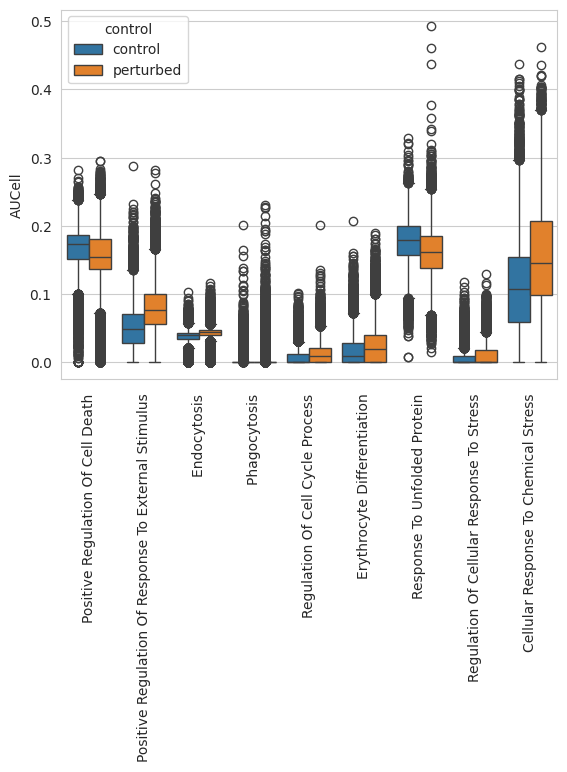

In [13]:
df = auc_mtx.melt(id_vars=['control'])
df['control'] = df['control'].replace({1: 'control', 0: 'perturbed'})
df['Regulon'] = df['Regulon'].str.split('(').str[0]
sns.boxplot(data=df,
            x='Regulon',
            y='value',
            hue='control',
            hue_order=['control', 'perturbed'])

"""
pairs = [
    (("Positive Regulation Of Cell Death ", "control"), ("Positive Regulation Of Cell Death ", "perturbed")),
]

for name,ax in g.axes_dict.items():
# subset the table otherwise the stats were calculated on the whole dataset
        annot = Annotator(ax, pairs, )  # **args,data=tips.loc[tips['time']==name,:] 
        annot.configure(test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)
        annot.apply_test().annotate()
"""

plt.ylabel('AUCell')
plt.xlabel('')
plt.xticks(rotation=90)

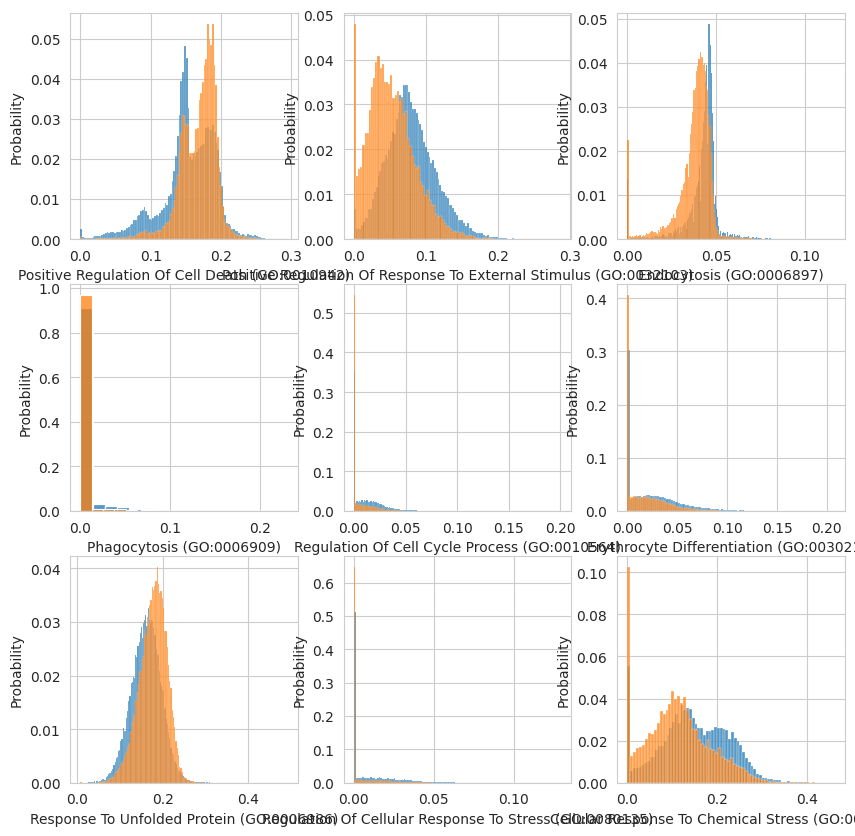

In [14]:
plt.figure(figsize=(10, 10))
for i, p in enumerate(selected_pathways):
    plt.subplot(3, 3, i+1)
    sns.histplot(auc_mtx[auc_mtx['control'] == 0][p], stat='probability')
    sns.histplot(auc_mtx[auc_mtx['control'] == 1][p], stat='probability')

In [15]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

In [16]:
for p in selected_pathways:
    adata.obs[p] = auc_mtx.loc[adata.obs.index][p]
adata.obs['control_str'] = adata.obs['control'].astype(str)

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


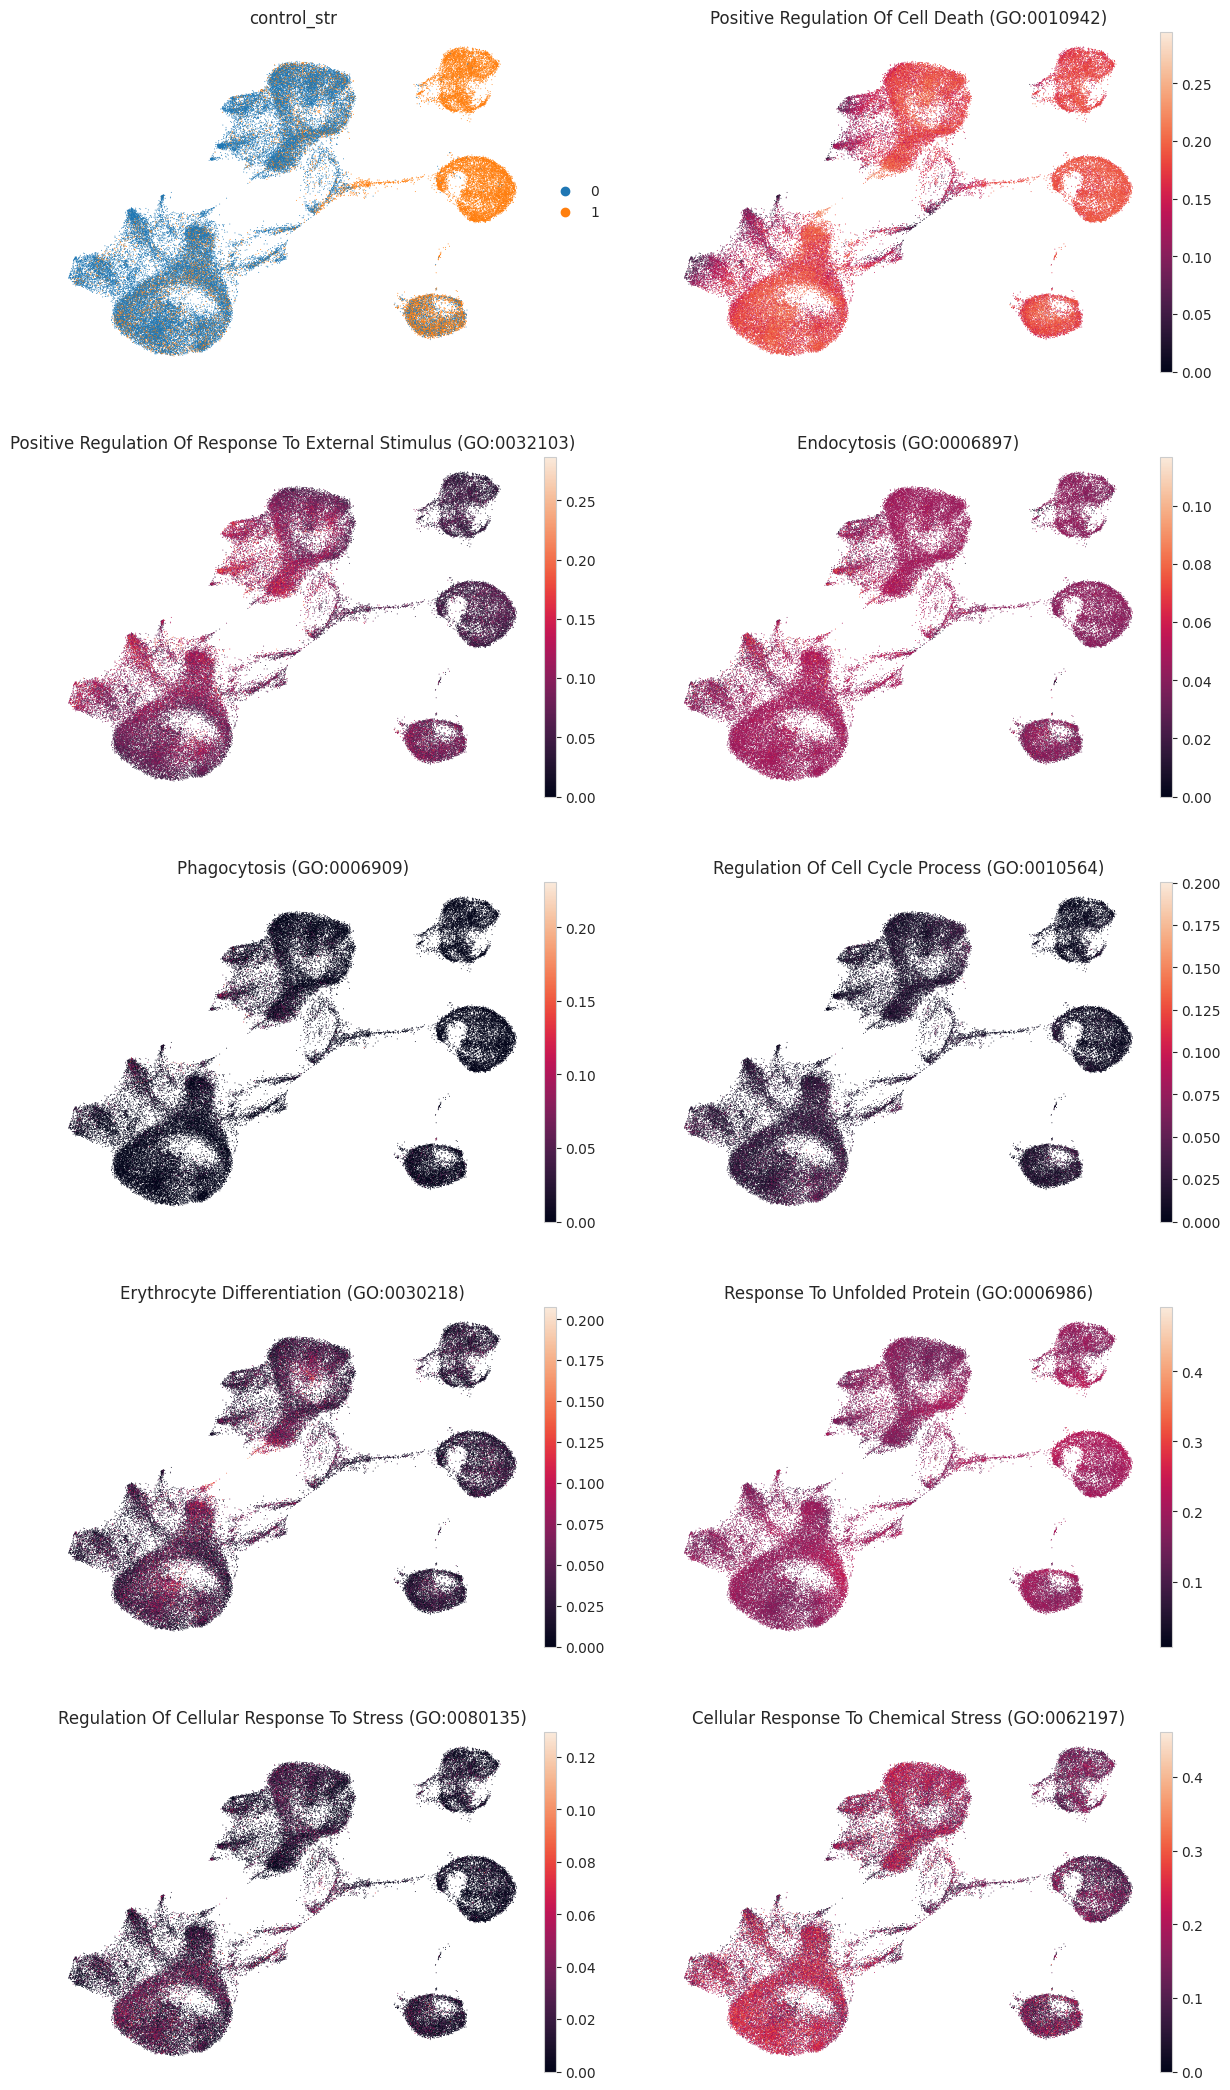

In [17]:
sc.pl.umap(
    adata,
    color=['control_str'] + list(np.array(selected_pathways)),
    ncols=2,
    frameon=False,
)

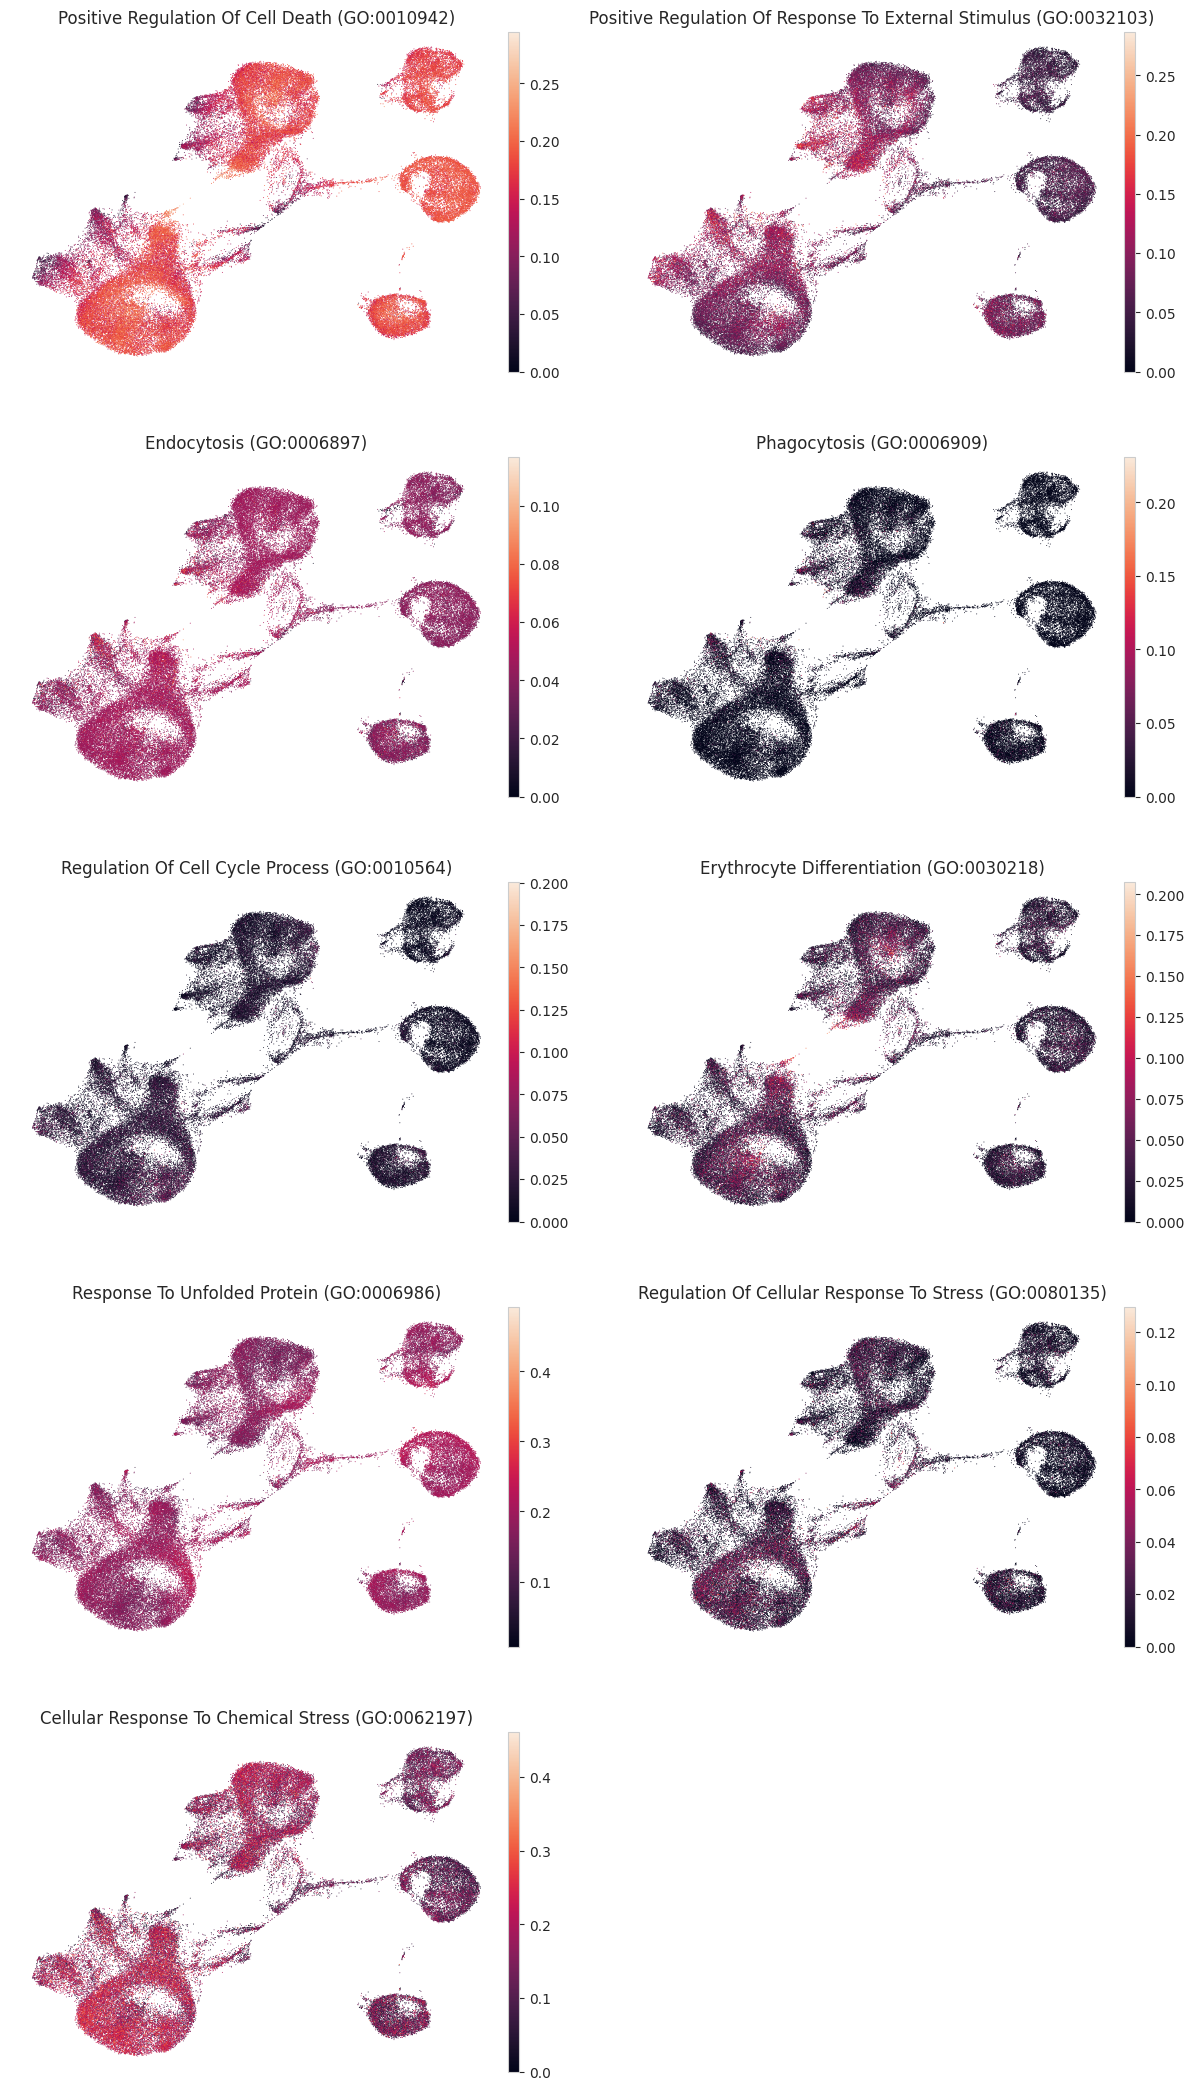

In [18]:
sc.pl.umap(
    adata,
    color=np.array(selected_pathways),
    ncols=2,
    frameon=False,
)

In [22]:
list(np.array(selected_pathways))

['Positive Regulation Of Cell Death (GO:0010942)',
 'Positive Regulation Of Response To External Stimulus (GO:0032103)',
 'Endocytosis (GO:0006897)',
 'Phagocytosis (GO:0006909)',
 'Regulation Of Cell Cycle Process (GO:0010564)',
 'Erythrocyte Differentiation (GO:0030218)',
 'Response To Unfolded Protein (GO:0006986)',
 'Regulation Of Cellular Response To Stress (GO:0080135)',
 'Cellular Response To Chemical Stress (GO:0062197)']

In [32]:
adata.obs['Control vs perturbed'] = ['control' if s == '1' else 'perturbed' for s in adata.obs['control_str']]

In [41]:
sc.settings.figdir = figdir

/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/vinas/.conda/envs/CPAenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


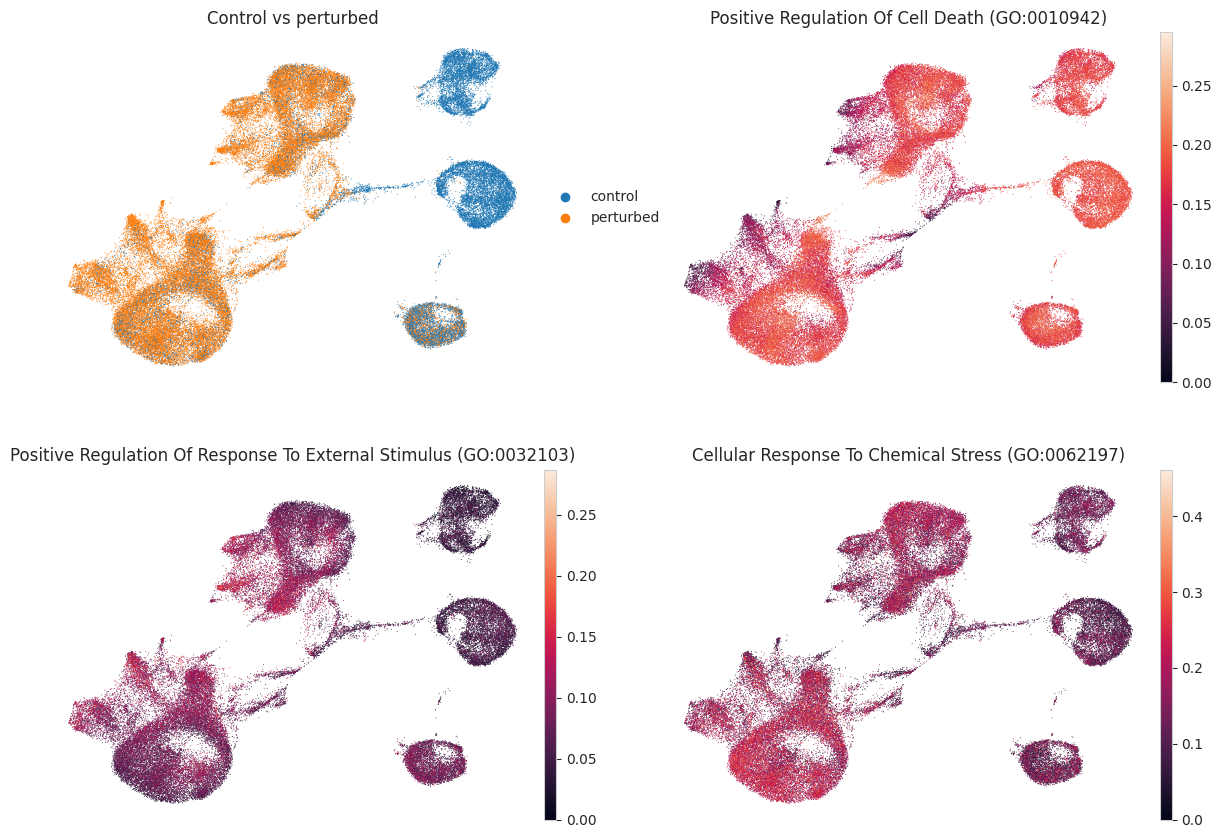

In [43]:
sc.pl.umap(
    adata,
    color=['Control vs perturbed', 'Positive Regulation Of Cell Death (GO:0010942)', 'Positive Regulation Of Response To External Stimulus (GO:0032103)', 'Cellular Response To Chemical Stress (GO:0062197)'],
    ncols=2,
    frameon=False,
    save=f'{dataset}_aucell.png'
)
# plt.tight_layout()
# plt.savefig(f'{figdir}/{dataset}_aucell.pdf')